In [1]:
from sklearn import datasets
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering
from numpy import linalg
import pandas as pd
from sklearn.datasets import load_digits
#import zoopt
import csv
from sklearn.utils import shuffle

In [2]:
#from scipy import optimize
import blackbox as bb

In [3]:
plotting_on = 0
cluster_size = 2
noise_threshold = 10.0
S = 1

In [4]:
def plot_clusters(X, labels):
    chosen_pts_cluster_label = []
    for idx, label in enumerate(labels):
        if label == 0:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'blue')

        if label == 1:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'red')

        if mask[idx] == 1:
            chosen_pts_cluster_label.append(label)
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'green')

    if plotting_on:
        plt.show()
    return chosen_pts_cluster_label

def get_Y(labels,n_samples, n_clusters):
    Y = np.zeros([n_samples, n_clusters])
    for idx, label in enumerate(labels):
        Y[idx, label] = 1
    return Y

def run_kmeans(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
    
def add_noise(X,noise):
    for i,(m,_) in enumerate(zip(mask,X)):
        if m != 0:
            X[i,:] = X[i,:] + noise
    return X

def get_dist(Y,Y_dash):
    dist = linalg.norm(np.matmul(Y,Y.T) - np.matmul(Y_dash,Y_dash.T))
    return dist


In [5]:
d = []                                                                          
with open('allUsers.lcl.csv') as f:                                             
    r = csv.reader(f, delimiter = ',')                                          
    idx = 0                                                                     
    for row in r:                                                               
        if idx == 0 or idx == 1:                                                
            idx += 1                                                            
                                                                                
        else:                                                                   
            nr = np.array(row)                                                  
            if d == []:                                                         
                #d = nr                                                         
                d.append(nr)                                                    
            else:
                #d = np.vstack((d, nr))                                         
                d.append(nr)                                                    
            idx += 1                                                            
                                                                                
y = np.array(d)[:,0]                                                            
d = np.array(d)[:,2:11]                                                         
d = np.float32(d)                                                               
y = np.float32(y)                                                               
#print(d,y)                                                                      
d = np.array(d)                                                                 
y = np.array(y)                                                                 
print(y.shape,d.shape)

X1 = d[y==3,:]                                                                  
X2 = d[y==5,:]                                                                  
y1 = y[y == 3]                                                                  
y2 = y[y == 5]                                                                  
X1, y1 = shuffle(X1,y1, random_state=42)                                        
X2, y2 = shuffle(X2,y2, random_state=42)                                        
X1 = X1[:200,:]                                                                 
X2 = X2[:200,:]                                                                 
y1 = y1[:200]                                                                   
y2 = y2[:200]                                                                   
X = np.vstack((X1, X2))                                                         
y = np.hstack((y1,y2))                                                          
print(X1.shape,X2.shape, X.shape, y.shape)

sample_size = X.shape[0]
mask = np.zeros((sample_size))
n_features = X.shape[1]

X_org = np.copy(X)

kmeans_d = KMeans(n_clusters = cluster_size, random_state=42)
labels_d = kmeans_d.fit_predict(X)    
centers_d = kmeans_d.cluster_centers_

temp_d = np.copy(labels_d)
temp_c_d = np.copy(centers_d)
if np.sum(centers_d[0,:]) < np.sum(centers_d[1,:]):
    labels_d[temp_d == 0] = 1
    labels_d[temp_d == 1] = 0
    centers_d[1,:] = temp_c_d[0,:]
    centers_d[0,:] = temp_c_d[1,:]


best_vals = []
for idx,label in enumerate(labels_d):
    if label == 1:
        best_vals.append(linalg.norm(X[idx,:] - centers_d[0,:]))
    else:
        best_vals.append(1000000)

best_vals = np.array(best_vals)
best_vals_idx = np.argsort(best_vals)

count = 0
mask_idx = -1
for idx in range(0,sample_size):
    if idx in best_vals_idx[:S]:
        mask[idx] = 1
        count+=1
        mask_idx = idx


((78095,), (78095, 9))
((200, 9), (200, 9), (400, 9), (400,))


In [6]:
def f(x):
    success = 0.0
    noise = np.array(x)
    (labels, centers) = run_kmeans(cluster_size, X_org)
    org_label = labels[mask_idx]
    Y = get_Y(labels, sample_size, cluster_size)
    X_noisy = np.copy(X_org)
    X_noisy  = add_noise(X_noisy, noise)
    (labels_dash, centers_dash) = run_kmeans(cluster_size, X_noisy)
    noisy_label = labels_dash[mask_idx]
    Y_dash = get_Y(labels_dash, sample_size, cluster_size)  
    dist = get_dist(Y,Y_dash)
    #if noisy_label != org_label and dist != 0.0:
    #    return -10000.0 - dist
    #else:
    #    return 1000000.0
    #    success = 1.0
    #return (linalg.norm(noise)-(dist + 10000*success))
    if dist != 0.0:
        #return -dist + linalg.norm(noise)
        return -dist
    else:
        return 1000000.0

In [7]:
bb.search(f=f,  # given function
          box=[[-20, 20]]*9,  # range of values for each parameter (2D case)
          n=50,  # number of function calls on initial stage (global search)
          m=50,  # number of function calls on subsequent stage (local search)
          batch=4,  # number of calls that will be evaluated in parallel
          resfile='kmeans_hands.csv')  # text file where results will be saved

In [7]:
best_noise = [-1.1897e+01, +1.2684e+01, -8.4040e+00, +1.4829e+01, +1.2117e+01, +5.7888e+00, -2.0000e+01, +2.0000e+01, +2.0000e+01]
np.save('kme_X_org.npy', X_org)
X_adv = np.copy(X_org)
X_adv = add_noise(X_adv, best_noise)
np.save('kme_X_adv.npy', X_adv)
print(mask_idx)

219


In [8]:
Xo = np.load('kme_X_org.npy')
Xa = np.load('kme_X_adv.npy')

lo,_ = run_kmeans(2, Xo)
la,_ = run_kmeans(2, Xa)

In [9]:
print(lo,la)
np.savetxt('la.csv', la, delimiter=',')
np.savetxt('lo.csv', lo, delimiter=',')

(array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0

In [10]:
print(lo[lo==0].shape, lo[lo==1].shape)
print(lo[mask_idx],la[mask_idx])

((191,), (209,))
(1, 0)


In [11]:
count_diffs = 0
perturbed_idx = []
for idx,(el1, el2) in enumerate(zip(lo,la)):
    if el1 != el2:
        count_diffs += 1
        perturbed_idx.append(idx)
print(count_diffs)

5


In [12]:
f(best_noise)

-62.849025449882674

In [13]:
for i in perturbed_idx:
    print(lo[i], la[i], y[i])

(1, 0, 3.0)
(1, 0, 5.0)
(1, 0, 5.0)
(1, 0, 5.0)
(1, 0, 5.0)


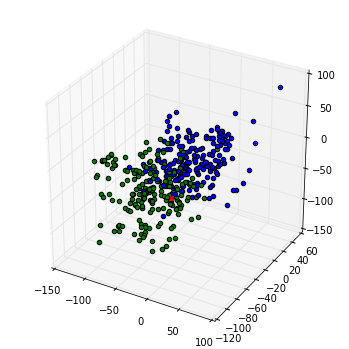

In [18]:
fig = plt.figure()
#fig2 = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(6)
#fig2.set_figheight(10)
#fig2.set_figwidth(10)
ax = fig.add_subplot(111, projection='3d')#
#ax2 = fig2.add_subplot(111, projection='3d')
#ax.scatter(Xo[:,0], Xo[:,1], Xo[:,2], c='r', marker='o')
for i,xo in enumerate(Xo):
    if i == mask_idx:
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            ax.scatter(xo[5], xo[2], xo[8], c='r', marker='x')
            continue
    if lo[i] == 0:        
        ax.scatter(xo[5], xo[2], xo[8], c='b', marker='o')
    if lo[i] == 1:        
        ax.scatter(xo[5], xo[2], xo[8], c='g', marker='o')
    
#for i,xa in enumerate(Xa):
#    if i in perturbed_idx:
#        ax2.scatter(xa[2], xa[1], xa[0], c='r', marker='x')
#    else:
#        ax2.scatter(xa[2], xa[1], xa[0], c='b', marker='o')
    

In [2]:
import numpy as np
np.max(X)

NameError: name 'X' is not defined